# Data Science Project Time Series - Petrobras Stock Price
The objective of this project is to forecast stock prices for the company Petrobras, a state-owned Brazilian multinational corporation in the petroleum industry. 
We have the stock prices of 2013 to 2018.
For this, we will use a Recurrent Neural Network (LSTM) and the Facebook Prophet algorithm. At the end we will compare the results between the models.
Let's jump right in!


In [1]:
# The necessary imports
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# I already split the training and test data.
# So let's load the training data first.
df = pd.read_csv('/content/drive/MyDrive/Deep Learning de A á Z/Fontes/Deep learning/redes neurais recorrentes/petr4_treinamento.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0


In [4]:
df.shape

(1242, 7)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1242 entries, 0 to 1244
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1242 non-null   object 
 1   Open       1242 non-null   float64
 2   High       1242 non-null   float64
 3   Low        1242 non-null   float64
 4   Close      1242 non-null   float64
 5   Adj Close  1242 non-null   float64
 6   Volume     1242 non-null   float64
dtypes: float64(6), object(1)
memory usage: 77.6+ KB


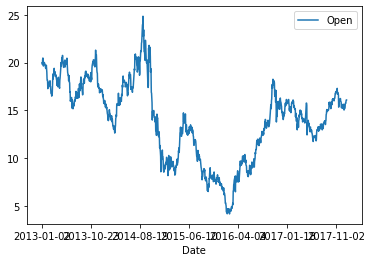

In [51]:
# Let's look at our data
df.plot(x='Date', y='Open', kind='line');

# Data Preparation

In [5]:
# We have some null values, so I gonna drop them.
df = df.dropna()

# Here we are just saving the "Open" column, since with time series and RNN's, we just work with the variable that we want to predict, which in this case is the "Open" price.
df_train = df.iloc[:, 1:2].values

In [7]:
# To minimize the train time, I gonna scale the data.
mms = MinMaxScaler(feature_range=(0,1))
df_train_mms = mms.fit_transform(df_train)

We are going to use 90 days to predict a price, that is, for each value that we want to predict, we will have 90 days prior as features.

For that, let's make a for loop, which will take 90 values ​​and put in the features variable, and the value 91 will go to the real price variable. This will be done successively for all data. Remembering that the price '91' will be part of the features to predict the following value.

In [8]:

features = []
real_price = []


for i in range(90, 1242):
    features.append(df_train_mms[i-90:i, 0])  # i-90 is equal to 0, which is the indice that we will start to add on the features list.
    real_price.append(df_train_mms[i, 0]) # The real price starts in the 90th index (the 91th price on the data), since we need 90 days to predict a price. 



In [ ]:
# now that we have our features, let's reshape them for the keras format needed. A 3D array.
features, real_price = np.array(features), np.array(real_price)
features = np.reshape(features, (features.shape[0], features.shape[1], 1))

# Modelling - LSTM

In [9]:
# Let's build are RNN LSTM.

regressor = Sequential()
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (features.shape[1], 1)))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.3))

regressor.add(Dense(units = 1, activation = 'linear'))

regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error',
                  metrics = ['mean_absolute_error'])
regressor.fit(features, real_price, epochs = 100, batch_size = 32)

Epoch 1/100
36/36 [==============================] - 13s 179ms/step - loss: 0.0338 - mean_absolute_error: 0.1289
Epoch 2/100
36/36 [==============================] - 6s 176ms/step - loss: 0.0189 - mean_absolute_error: 0.1045
Epoch 3/100
36/36 [==============================] - 6s 178ms/step - loss: 0.0148 - mean_absolute_error: 0.0947
Epoch 4/100
36/36 [==============================] - 6s 176ms/step - loss: 0.0126 - mean_absolute_error: 0.0856
Epoch 5/100
36/36 [==============================] - 6s 176ms/step - loss: 0.0097 - mean_absolute_error: 0.0763
Epoch 6/100
36/36 [==============================] - 6s 175ms/step - loss: 0.0092 - mean_absolute_error: 0.0731
Epoch 7/100
36/36 [==============================] - 6s 175ms/step - loss: 0.0090 - mean_absolute_error: 0.0717
Epoch 8/100
36/36 [==============================] - 6s 175ms/step - loss: 0.0081 - mean_absolute_error: 0.0691
Epoch 9/100
36/36 [==============================] - 6s 173ms/step - loss: 0.0071 - mean_absolute_error

We trained our neural network.
See that the MAE metric reached 0.03, which is very good.
But that was in the training data.
Now let's load the test data and see if our model has generalized well and can follow the trend and seasonality of prices.

# Evaluating - LSTM

In [11]:
# loading the test data
df_test = pd.read_csv('/content/drive/MyDrive/Deep Learning de A á Z/Fontes/Deep learning/redes neurais recorrentes/petr4_teste.csv')

# Saving the real price for later evaluation
real_price_test = df_test.iloc[:, 1:2].values

# Concatenating the train and test data
df_complete = pd.concat((df['Open'], df_test['Open']), axis = 0)

# Gettig the 90 last values
inputs = df_complete[len(df_complete) - len(df_test) - 90:].values
inputs = inputs.reshape(-1, 1)
# Scaling again
inputs = mms.transform(inputs)


In [12]:
# Same loop as before, but now to get the test data.
# Our test data have just 22 rows, so that is the number of prices that we want to predict here.
X_test = []

for i in range(90, 112):
    X_test.append(inputs[i-90:i, 0])

# Reshaping the test data for the keras format, a 3D array.
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [52]:
X_test.shape

(22, 90, 1)

In [ ]:
# So let's make our predictions for 22 days.

y_hat = regressor.predict(X_test)
y_hat = mms.inverse_transform(y_hat)

In [49]:
y_hat.mean(), real_price_test.mean()

(17.53653, 17.87454563636364)

In [53]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(real_price_test, y_hat)

0.3380156618596862

Very good result!  Our model errs on average only 3 cents.

Let's see in the graph whether the model followed the trend.

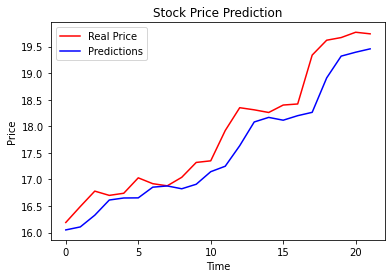

In [54]:
plt.plot(real_price_test, color = 'red', label = 'Real Price')
plt.plot(y_hat, color = 'blue', label = 'Predictions')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

The model had a great result and captured the market trend well!


Now let's test Facebook's Prophet algorithm.

## Facebook Prophet

Prophet needs the data in a custom format for it.
The data needs to contain a column called "ds" with the dates, and a column called "y" with the variable that we want to predict.
In this case it is the "Open" column.

In [32]:
# Creating the full dataset
complete = pd.concat([df, df_test])
complete.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0
...,...,...,...,...,...,...,...
17,2018-01-25,19.340000,19.340000,19.340000,19.340000,19.301397,0.0
18,2018-01-26,19.620001,19.980000,19.100000,19.930000,19.890221,81989500.0
19,2018-01-29,19.670000,20.049999,19.570000,19.850000,19.810381,55726200.0
20,2018-01-30,19.770000,19.770000,19.360001,19.490000,19.451097,46203000.0


In [33]:
# Here we are saving just the 2 columns needed for the prophet and renaming the columns.
df2 = complete[['Date', "Open"]] 
df2.rename(columns={"Date" : 'ds', "Open": 'y'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [34]:
# Are new dataframe for the prophet.
df2

,ds,y
0,2013-01-02,19.990000
1,2013-01-03,19.809999
2,2013-01-04,20.330000
3,2013-01-07,20.480000
4,2013-01-08,20.110001
...,...,...
17,2018-01-25,19.340000
18,2018-01-26,19.620001
19,2018-01-29,19.670000
20,2018-01-30,19.770000


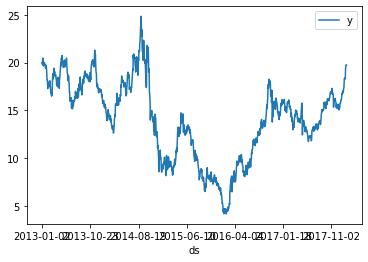

In [35]:
df2.plot(x='ds', y='y', kind='line');

Lastly, let's remove the last 22 records from the dataset and pass the rest to Prophet to train.
Then we will make a forecast  for the next 22 records and compare the forecast results with the actual ones, just like we did with RNN.

In [ ]:
# getting all rows, except the last 22.
train = df2[:-22]

In [57]:
train.shape

(1242, 2)

In [ ]:
# getting the last 22 rows.
test = df2.tail(22)

In [56]:
test.shape

(22, 2)

# Modelling - Prophet

In [36]:
from fbprophet import Prophet

In [58]:
# Creating the model
m = Prophet(interval_width=0.95, daily_seasonality=True)
model = m.fit(train)

In [59]:
# this is a variable that contains the period that we wanna to predict. As I said before, we wanna to predict 22 days.
future = m.make_future_dataframe(periods=22,freq='D')

# Making the predictions
forecast = m.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-02,20.035269,16.889176,22.918446,20.035269,20.035269,-0.201099,-0.201099,-0.201099,0.679772,0.679772,0.679772,0.020553,0.020553,0.020553,-0.901424,-0.901424,-0.901424,0.0,0.0,0.0,19.834170
1,2013-01-03,20.018255,16.758439,22.868541,20.018255,20.018255,-0.224503,-0.224503,-0.224503,0.679772,0.679772,0.679772,0.036121,0.036121,0.036121,-0.940395,-0.940395,-0.940395,0.0,0.0,0.0,19.793752
2,2013-01-04,20.001241,16.741417,22.749750,20.001241,20.001241,-0.289187,-0.289187,-0.289187,0.679772,0.679772,0.679772,0.011155,0.011155,0.011155,-0.980114,-0.980114,-0.980114,0.0,0.0,0.0,19.712054
3,2013-01-07,19.950199,16.426339,22.612061,19.950199,19.950199,-0.357877,-0.357877,-0.357877,0.679772,0.679772,0.679772,0.065556,0.065556,0.065556,-1.103204,-1.103204,-1.103204,0.0,0.0,0.0,19.592322
4,2013-01-08,19.933185,16.231872,22.531464,19.933185,19.933185,-0.428990,-0.428990,-0.428990,0.679772,0.679772,0.679772,0.036557,0.036557,0.036557,-1.145319,-1.145319,-1.145319,0.0,0.0,0.0,19.504195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1259,2018-01-16,13.078824,9.143840,15.239954,13.003838,13.149246,-0.763342,-0.763342,-0.763342,0.679772,0.679772,0.679772,0.036557,0.036557,0.036557,-1.479670,-1.479670,-1.479670,0.0,0.0,0.0,12.315483
1260,2018-01-17,13.074993,9.247391,15.281192,12.987914,13.152098,-0.822377,-0.822377,-0.822377,0.679772,0.679772,0.679772,0.020553,0.020553,0.020553,-1.522702,-1.522702,-1.522702,0.0,0.0,0.0,12.252616
1261,2018-01-18,13.071163,9.289451,15.364285,12.978285,13.153047,-0.849546,-0.849546,-0.849546,0.679772,0.679772,0.679772,0.036121,0.036121,0.036121,-1.565439,-1.565439,-1.565439,0.0,0.0,0.0,12.221617
1262,2018-01-19,13.067332,8.845189,15.075605,12.966517,13.153848,-0.916860,-0.916860,-0.916860,0.679772,0.679772,0.679772,0.011155,0.011155,0.011155,-1.607787,-1.607787,-1.607787,0.0,0.0,0.0,12.150472


The Prophet model predictions contain several interesting metrics, including it gives us a confidence interval for the predictions.

Let's just focus on the last column of this dataframe, which is the "y_hat" column that contains the predictions.

But Prophet returns the entire dataset along with the predictions, so our predictions are the last 22 records of this dataframe.

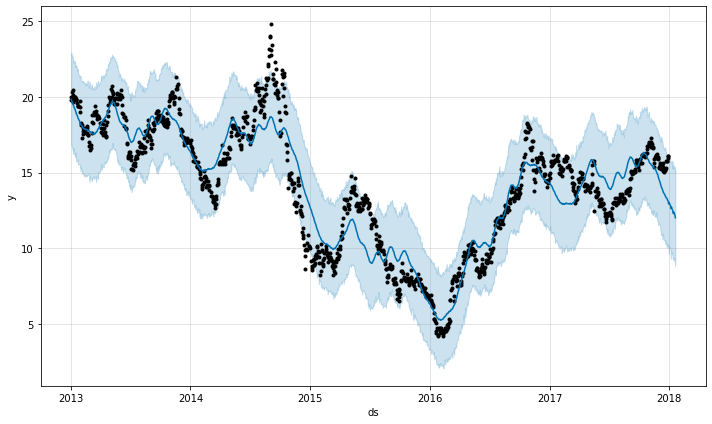

In [60]:
# Here we can plot the graph with the real prices and with the predict ones.
# We can see the trend also.
plot1 = m.plot(forecast)

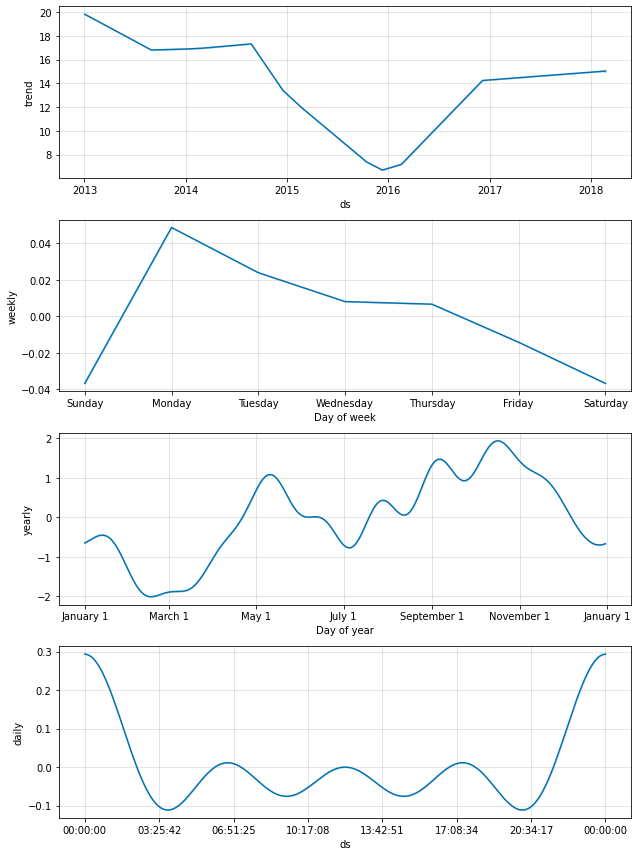

In [40]:
# This function allows us to decompose are data, and see things such as the trend for year, week and day.
plt2 = m.plot_components(forecast)

So now, let's evaluate the Prophet results.

# Evaluation - Prophet

In [46]:
# Getting the real 22 prices.
real_price = test['y'].values

# Getting the last 22 rows of the "yhat" colum.
# As we said above, the Prophet adds the predictions to the original dataframe.
predictions = forecast['yhat'].tail(22).values

In [47]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(real_price, predictions)
# we have a higher MAE

4.396770329825301

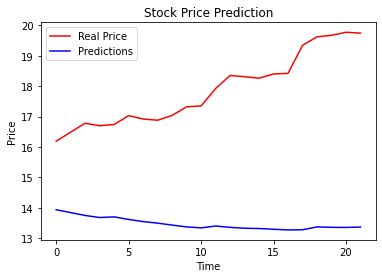

In [62]:
# Let's plot
plt.plot(real_price, color = 'red', label = 'Real Price')
plt.plot(predictions, color = 'blue', label = 'Predictions')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


# Conclusion:

Our neural network was able to capture the trend in the stock price much better, and with an mean absolute error of only 0.3 cents.

The Prophet algorithm failed to capture the trend well, and had an absolute mean error of 4 dollars.

I believe that both models can be improved, either with more data or changing hyperparameters.


So I close this time series project on Petrobras share prices.
I hope that you enjoyed.
See ya!